In [ ]:
#Intial analysis of getting population count was performed in first_model.ipynb file

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/coviddatawithpopulation/train_data_with_population.csv
/kaggle/input/coviddatawithpopulation/test_data_with_population.csv
/kaggle/input/covid19-global-forecasting-week-1/submission.csv
/kaggle/input/covid19-global-forecasting-week-1/test.csv
/kaggle/input/covid19-global-forecasting-week-1/train.csv


This notebook has taken covid 19 dataset considered 3 files Train Test and Submission

* As part of data preprocessing step. I have performed below:

      Renaming of attributes

* Extracted Below Features:

      Performed Frequency Enconding on Country
      From Data Field extracted Year, Month, WeekNumber and Day
      Extracted total population of all countries using restcountries python package in local pc. In Kaggle Kernel I was unable to perform. Hence reloaded train and test data again into Kaggle
      
* Model Used
  
      Generalized additive Model



In [2]:
!pip install restcountries
!pip install pygam

     |████████████████████████████████| 88 kB 1.9 MB/s 
     |████████████████████████████████| 56 kB 3.6 MB/s 
     |████████████████████████████████| 132 kB 58.9 MB/s 
  Created wheel for restcountries: filename=restcountries-1.1.0-py2.py3-none-any.whl size=6605 sha256=b06dcd4facd1a5d8f241b1957d5587c297e11f7c70fb95ac886a32b24efe27be
  Stored in directory: /root/.cache/pip/wheels/76/3b/be/106d2ab9ddd3b91c218f726b8239be2975e5536f1907f2ec82
Successfully built restcountries
ERROR: pytest-astropy 0.8.0 requires pytest-filter-subpackage>=0.1, which is not installed.
ERROR: tensorflow 2.1.0 has requirement six>=1.12.0, but you'll have six 1.11.0 which is incompatible.
ERROR: tensorboard 2.1.1 has requirement requests<3,>=2.21.0, but you'll have requests 2.18.4 which is incompatible.
ERROR: pandas-profiling 2.5.0 has requirement requests==2.22.0, but you'll have requests 2.18.4 which is incompatible.
ERROR: osmnx 0.10 has requirement requests>=2.21, but you'll have requests 2.18.4 which is i

In [3]:
#Imports all required packages
from pygam import LinearGAM, s, f
from pygam import PoissonGAM, s, te
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import Lasso
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import log_loss
#from restcountries import RestCountryApiV2 as rapi

In [4]:
#Read Data
train_data=pd.read_csv("../input/covid19-global-forecasting-week-1/train.csv")
test_data=pd.read_csv("../input/covid19-global-forecasting-week-1/test.csv")
#I have read above data in local added population for all 163 countried and uplodaed same data here . As commented in above from import packages restcountries is not working 
train_data=pd.read_csv("../input/coviddatawithpopulation/train_data_with_population.csv")
test_data=pd.read_csv("../input/coviddatawithpopulation/test_data_with_population.csv")
submission_data=pd.read_csv("../input/covid19-global-forecasting-week-1/submission.csv")

In [5]:
#EDA
train_data.groupby(['Country','ConfirmedCases','Fatalities']).sum()

Id        Lat       Long    Year  \
Country     ConfirmedCases Fatalities                                          
Afghanistan 0.0            0.0             561  1089.0000  2145.0000   66660   
            1.0            0.0             520   429.0000   845.0000   26260   
            4.0            0.0              95    66.0000   130.0000    4040   
            5.0            0.0              49    33.0000    65.0000    2020   
            7.0            0.0             153    99.0000   195.0000    6060   
...                                        ...        ...        ...     ...   
Vietnam     94.0           0.0           26286    16.0000   108.0000    2020   
            113.0          0.0           26287    16.0000   108.0000    2020   
Zambia      0.0            0.0         1475460  -863.3352  1583.8648  113120   
            2.0            0.0          105510   -61.6668   113.1332    8080   
            3.0            0.0           26380   -15.4167    28.2833    2020   

                                       Month  WeekNumber  Day  population  
Country     ConfirmedCases Fatalities                                      
Afghanistan 0.0            0.0            56         202  541   912685785  
            1.0            0.0            33         123  187   359542885  
            4.0            0.0             6          21   17    55314290  
            5.0            0.0             3          11   10    27657145  
            7.0            0.0             9          33   36    82971435  
...                                      ...         ...  ...         ...  
Vietnam     94.0           0.0             3          12   21           0  
            113.0          0.0             3          12   22           0  
Zambia      0.0            0.0           119         436  853   892297448  
            2.0            0.0            12          48   78    63735532  
            3.0            0.0             3          12   22    15933883  

[3246 rows x 8 columns]

In [6]:
#Selecting attributes id,country,confirmed cases, fatalities,week,day,month and year
train_data_processed=train_data.iloc[:,[0,2,6,7,9,10,11,12,13]]
test_data_processed=test_data.iloc[:,[0,2,6,7,8,9,10,11]]

In [7]:
#Performing frequency enconding on country
fe_train=train_data_processed.groupby('Country').size()/len(train_data_processed)
fe_test=train_data_processed.groupby('Country').size()/len(train_data_processed)
train_data_processed.loc[:,'Country_Encode']=train_data_processed['Country'].map(fe_train)
train_data_processed["Country_Encode"]=((train_data_processed["Country_Encode"]-train_data_processed["Country_Encode"].min())/(train_data_processed["Country_Encode"].max()-train_data_processed["Country_Encode"].min()))*20
fe=test_data_processed.groupby('Country').size()/len(test_data_processed)
test_data_processed.loc[:,'Country_Encode']=test_data_processed['Country'].map(fe_test)
test_data_processed["Country_Encode"]=((test_data_processed["Country_Encode"]-test_data_processed["Country_Encode"].min())/(test_data_processed["Country_Encode"].max()-test_data_processed["Country_Encode"].min()))*20

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [8]:
#Below attributes normalizes all attributes between 0 to 1 other than Id column
def normalize(dataset):
    dataNorm=((dataset-dataset.min())/(dataset.max()-dataset.min()))*1
    dataNorm["Id"]=dataset["Id"]
    return dataNorm

In [9]:
#Below attributes selects only country encoded along with population and date fields
numeric_train_set=train_data_processed.iloc[:,[0,2,3,4,5,6,7,8,9]]
numeric_test_set=test_data_processed.iloc[:,[0,2,4,5,6,7,8]]

In [10]:
#Below attribute calls normalize function defined above to normalize all values between 0 and 1
data_train=normalize(numeric_train_set)
data_test=normalize(numeric_test_set)

In [11]:
#Below selection attributes to train model for fatalities
predictors=["Id","Month","WeekNumber","Day","Country_Encode","population"]
target_column=["Fatalities"]

In [12]:
#Divide data into train and test set
X_train_gam, X_test_gam, y_train_gam, y_test_gam = train_test_split(data_train[predictors].values, data_train[target_column].values, test_size=0.20, random_state=40)

In [13]:
#Below code trains the model with 1000 splines
gam = PoissonGAM(s(0, n_splines=1300) + te(3,5) +s(1)+s(2)).fit(X_train_gam, y_train_gam)

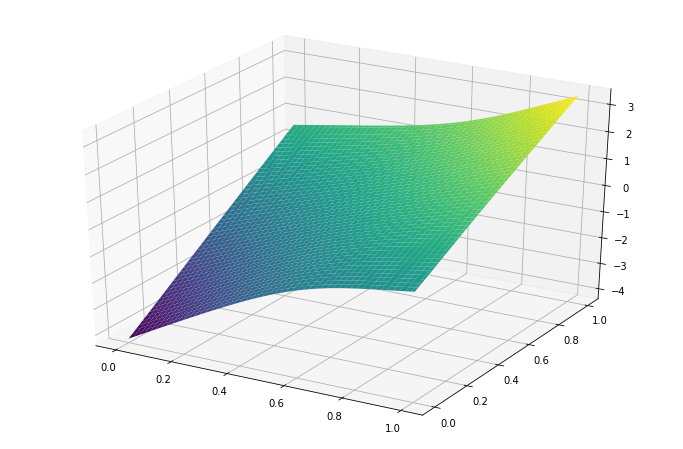

In [14]:
#Below code gives the view of model
plt.ion()
plt.rcParams['figure.figsize'] = (12, 8)
plt.ion()
plt.rcParams['figure.figsize'] = (12, 8)
XX = gam.generate_X_grid(term=1, meshgrid=True)
Z = gam.partial_dependence(term=1, X=XX, meshgrid=True)

ax = plt.axes(projection='3d')
ax.plot_surface(XX[0], XX[1], Z, cmap='viridis')

In [15]:
#Below code gives the summary of model, Summary has the rsquared value
gam.summary()

PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     96.3195
Link Function:                          LogLink Log Likelihood:                                   -38.3114
Number of Samples:                        13859 AIC:                                              269.2617
                                                AICc:                                             270.6524
                                                UBRE:                                                 2.02
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.9719
Feature Function                  Lam

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  


In [16]:
#Below code checks the accuracy on test data
predictions = gam.predict(X_test_gam)
print("Mean Square Log Error(MSLE) is "+str(np.sqrt(mean_squared_log_error( y_test_gam, predictions ))))
print("Mean Square Error(MSE) is "+str(np.sqrt(mean_squared_error(y_test_gam,predictions))))
print("RSquare is(R2) "+str(r2_score(y_test_gam, predictions)))
#We could see accuaracy of the model as 94 %
#As requested mean square log error is 0.006

Mean Square Log Error(MSLE) is 0.004587722861960945
Mean Square Error(MSE) is 0.006995365901128543
RSquare is(R2) 0.9497427324355496


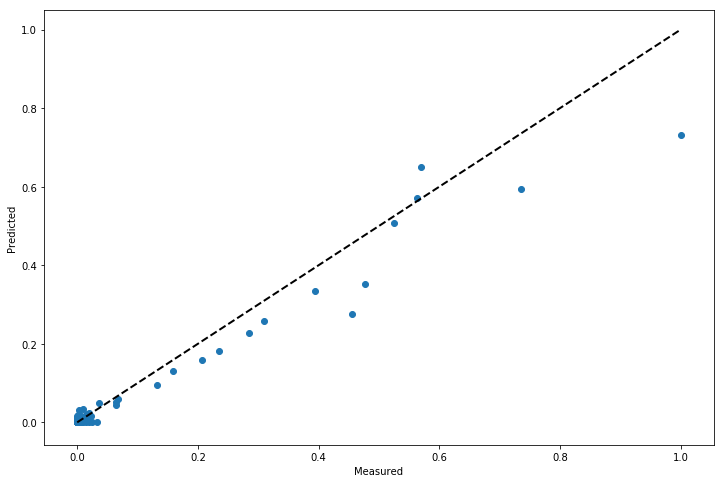

In [17]:
#Below code plots actual vs predicted Scatter plot view
fig, ax = plt.subplots()
ax.scatter(y_test_gam, predictions)
ax.plot([y_test_gam.min(), y_test_gam.max()], [y_test_gam.min(), y_test_gam.max()], 'k--', lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

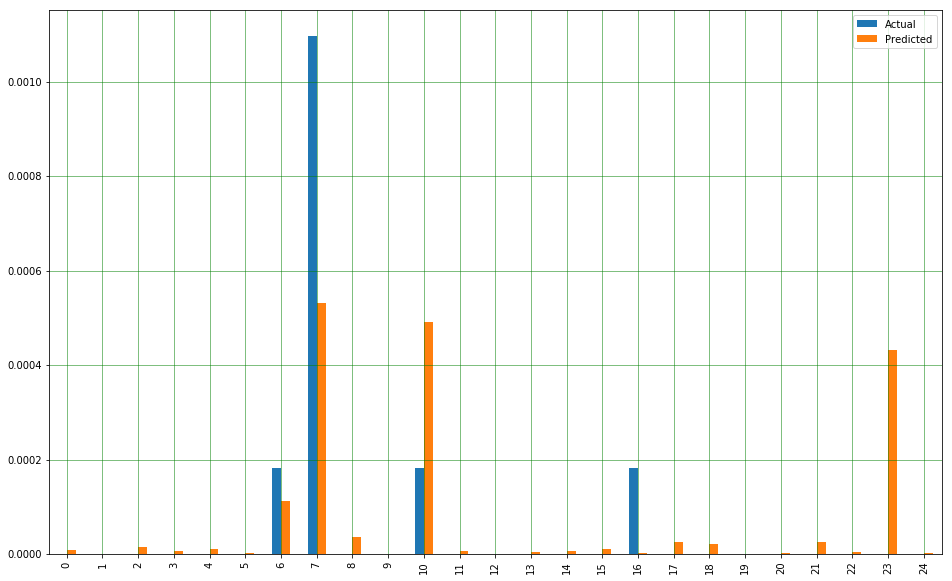

In [18]:
#Below code plots actual vs predicted Bar plot view

df = pd.DataFrame({'Actual': y_test_gam.flatten(), 'Predicted': predictions.flatten()})
df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [19]:
#Below code predicts on test data
predictions = gam.predict(data_test[predictors].values)

In [20]:
submission_data['Fatalities']=predictions

In [21]:
#Below selection attributes to train model for Confirmed Cases
predictors_cc=["Id","Month","WeekNumber","Day","Country_Encode","population"]
target_column_cc=["ConfirmedCases"]

In [22]:
#Divide data into train and test set
X_train_gam_cc, X_test_gam_cc, y_train_gam_cc, y_test_gam_cc = train_test_split(data_train[predictors_cc].values, data_train[target_column_cc].values, test_size=0.20, random_state=40)

In [23]:
#Below code trains the model with 3500 splines
gam_confirmed_cases = PoissonGAM(s(0, n_splines=3500) + te(3,5) +s(1)+s(2)+s(4)).fit(X_train_gam_cc, y_train_gam_cc)

In [24]:
gam_confirmed_cases.summary()

PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                    249.2104
Link Function:                          LogLink Log Likelihood:                                   -63.9636
Number of Samples:                        13859 AIC:                                               626.348
                                                AICc:                                             635.5862
                                                UBRE:                                               2.0508
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.986
Feature Function                  Lam

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


In [25]:
#Below code checks the accuracy on test data on confirmed cases
predictions_cc = gam_confirmed_cases.predict(X_test_gam_cc)
print("Mean Square Log Error(MSLE) is "+str(np.sqrt(mean_squared_log_error( y_test_gam_cc, predictions_cc ))))
print("Mean Square Error(MSE) is "+str(np.sqrt(mean_squared_error(y_test_gam_cc,predictions_cc))))
print("R Square(R2) is "+str(r2_score(y_test_gam_cc, predictions_cc)))
#We could see accuaracy of the model as 98 %
#As requested mean square log error is 0.0033

Mean Square Log Error(MSLE) is 0.003373337723277199
Mean Square Error(MSE) is 0.0047899443614219375
R Square(R2) is 0.9897788714648323


In [26]:
#Beloc code predicts confirmed cases for future data
predictions_cc_sub = gam_confirmed_cases.predict(data_test[predictors].values)

In [27]:
submission_data['ConfirmedCases']=predictions_cc_sub
submission_data.describe()

,ForecastId,ConfirmedCases,Fatalities
count,12212.000000,1.221200e+04,1.221200e+04
mean,6106.500000,2.046062e-03,8.914944e-04
std,3525.445078,1.387384e-02,7.118020e-03
min,1.000000,5.644984e-09,2.011369e-09
25%,3053.750000,3.730467e-06,5.795352e-07
50%,6106.500000,3.522425e-05,6.955011e-06
75%,9159.250000,3.503264e-04,6.531805e-05
max,12212.000000,3.746173e-01,2.167418e-01


In [28]:
#Below is the submission Data
submission_data=submission_data.round(4)
submission_data.to_csv('submission.csv',index=False)